In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [25]:
df = pd.read_excel("./data/SWAT.xlsx")
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 7:50:00 AM,2.462287,541.3740,2,1,1,260.7344,8.409895,324.8398,0.000513,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
1,28/12/2015 7:50:01 AM,2.441469,541.4918,2,1,1,260.7344,8.412138,324.3015,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
2,28/12/2015 7:50:02 AM,2.428338,541.2955,2,1,1,260.7344,8.414701,323.7888,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
3,28/12/2015 7:50:03 AM,2.425776,542.5124,2,1,1,260.7344,8.420149,323.3530,0.000256,...,2,1,251.4580,1.441707,190.1436,0.000064,1,1,1,Normal
4,28/12/2015 7:50:04 AM,2.424174,542.7871,2,1,1,260.7344,8.423674,322.8916,0.000256,...,2,1,251.2817,1.441707,190.1436,0.000064,1,1,1,Normal


In [26]:
df['Normal/Attack'].replace({'Normal':0, 'Attack':1}, inplace=True)
df["anomaly"] = df["Normal/Attack"]

anomaly = df.anomaly
df.drop(["Normal/Attack"], axis=1, inplace=True)

In [27]:
important_features = [
    'LIT101', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'AIT401', 'AIT504', 'FIT504', 'PIT502', 'P602', 'anomaly']

In [28]:
df = df[important_features]
df.head()

,LIT101,MV301,MV302,MV303,MV304,P302,AIT401,AIT504,FIT504,PIT502,P602,anomaly
0,541.3740,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
1,541.4918,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
2,541.2955,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
3,542.5124,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1,0
4,542.7871,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1,0


In [8]:
first_anomaly_index = anomaly[anomaly == 1].index[0]
train_size = int(first_anomaly_index * 0.8)

### Autoencoder prediction

In [15]:
from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler

In [33]:
from utils.pipeline import Pipeline, Predictor
from models.lstm_ae import LSTM_AE
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 3
    batch_size = 10 
    Q = 0.99
    
conf = Config
conf.train_size = train_size

class LSTM_AE_2ndPredictor:
    def fit(self, df_train):
        ss = StandardScaler()
        self.ss = ss
        x_train = df_train[:train_size].drop(["anomaly"], axis=1)
        x_train = np.array(ss.fit_transform(x_train))
        x_train = create_sequences(x_train, conf.TIME_STEPS)

        self.model = LSTM_AE(optimizer=optimizer, loss='mae')
        self.model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            df.drop(["anomaly"], axis=1, inplace=True)
            x_test = np.array(self.ss.transform(df))
            x_test = create_sequences(x_test, conf.TIME_STEPS)
            r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_test) - x_test), axis=1), axis=1)) 
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            a = smoothed.diff(10).abs()
            
            IQR = a.quantile(0.75) - a.quantile(0.75)
            UCL = a.quantile(0.75) + 1.5 * IQR
            
            s = a > UCL
            w = 10
            is_anomaly = s.rolling(window = w).mean().fillna(s.iloc[0])
            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) #+ conf.TIME_STEPS - 1

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [43]:
%%time
predictor = LSTM_AE_2ndPredictor()
predictor.fit(df[:train_size])

Epoch 1/3
1005/1005 [==============================] - 239s 228ms/step - loss: 0.3111
Epoch 2/3
1005/1005 [==============================] - 252s 251ms/step - loss: 0.2050
Epoch 3/3
1005/1005 [==============================] - 202s 201ms/step - loss: 0.1802
CPU times: user 22min 19s, sys: 1min 28s, total: 23min 48s
Wall time: 12min 33s


In [44]:
%%time
df_by_names = {"swat": df[train_size:]}
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

CPU times: user 1min 1s, sys: 4.77 s, total: 1min 6s
Wall time: 38.6 s


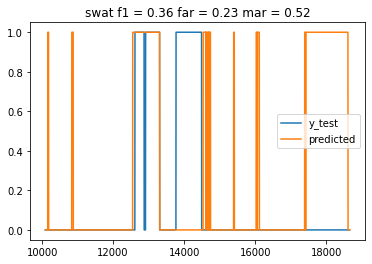

In [45]:
from utils.metrics import f1_score, far, mar
metrics= {}
predictions = []

draw = 1

all_prediction = {"swat": []}
all_test = {"swat": []}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    all_prediction["swat"].append(prediction)
    all_test["swat"].append(prediction)
            
    metrics[file_name] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

In [46]:
from utils.data import show_score_table

show_score_table(metrics)

metric | swat
--- | ---
F1 |0.36
FAR |0.23
MAR |0.52

### SKAB

In [47]:
# libraries importing
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [50]:
def arch(data):
    EPOCHS = 3
    BATCH_SIZE = 16
    VAL_SPLIT = 0.1
    
    # model defining
    # define encoder
    inputs = keras.Input(shape=(data.shape[1], data.shape[2]))
    encoded = layers.LSTM(100, activation='relu')(inputs)

    # define reconstruct decoder
    decoded = layers.RepeatVector(data.shape[1])(encoded)
    decoded = layers.LSTM(100, activation='relu', return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(data.shape[2]))(decoded)

    # tie it together
    model = keras.Model(inputs, decoded)
    encoder = keras.Model(inputs, encoded)

    model.compile(optimizer='adam', loss='mae', metrics=["mse"])
    
    # callbacks defining
    early_stopping = EarlyStopping(patience=5, verbose=0)
#     reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=0)
    
    # model fitting
    history = model.fit(data, data,
                        validation_split=VAL_SPLIT,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0,
                        shuffle=False,
                        callbacks=[early_stopping]#, reduce_lr]
                        )
    return history, model

In [54]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 3
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_SKAB_Predictor:
    def fit(self, df_train):
        ss = StandardScaler()
        self.ss = ss
        x_train = df_train[:train_size].drop(["anomaly"], axis=1)
        x_train = np.array(ss.fit_transform(x_train))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        _, model = arch(x_train)# ~ fit
        self.model = model
        
        healthy_r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_train) - x_train), axis=1), axis=1)) 
        self.UCL = healthy_r.quantile(conf.Q)
            
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            df.drop(["anomaly"], axis=1, inplace=True)
            x_test = np.array(self.ss.transform(df))
            x_test = create_sequences(x_test, conf.TIME_STEPS)
            r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_test) - x_test), axis=1), axis=1)) 
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            a = smoothed.diff(10).abs()
            
            IQR = a.quantile(0.75) - a.quantile(0.75)
            UCL = a.quantile(0.75) + 1.5 * IQR
            
            s = a > UCL
            w = 10
            is_anomaly = s.rolling(window = w).mean().fillna(s.iloc[0])
            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) #+ conf.TIME_STEPS - 1

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [55]:
%%time
skab_predictor = LSTM_AE_SKAB_Predictor()
skab_predictor.fit(df[:train_size])

CPU times: user 7min 53s, sys: 34.5 s, total: 8min 27s
Wall time: 4min 4s


In [56]:
%%time
predictions_by_names = skab_predictor.predict(df_by_names)

CPU times: user 29.4 s, sys: 2.83 s, total: 32.3 s
Wall time: 16.5 s


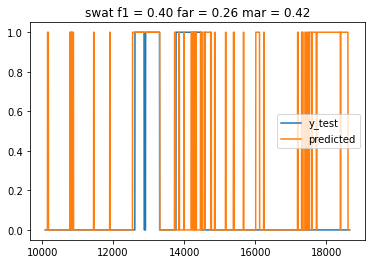

In [57]:
from utils.metrics import f1_score, far, mar
metrics= {}
predictions = []

draw = 1

all_prediction = {"swat": []}
all_test = {"swat": []}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    all_prediction["swat"].append(prediction)
    all_test["swat"].append(prediction)
            
    metrics[file_name] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

In [58]:
from utils.data import show_score_table

show_score_table(metrics)

metric | swat
--- | ---
F1 |0.4
FAR |0.26
MAR |0.42